<a href="https://colab.research.google.com/github/supertime1/BP_PPG/blob/master/Visualization/Model_Analysis_Vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction



This notebook analyze the BP-DL model in the following aspects:


*   Accuracy
*   Computational Cost
*   Model Visualization










#2. Setup Environment

In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation,\
MaxPooling1D,Dropout,Flatten,TimeDistributed,Bidirectional,Dense,LSTM, ZeroPadding1D, \
AveragePooling1D,GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector,\
Lambda, Average
from tensorflow.keras.initializers import glorot_uniform
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle
print(tf.__version__)

2.2.0


# 3.Model Performance

In [2]:
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Blood pressure\BP data\models\125Hz 10mmHg\ResNet-18+Attention")
model = tf.keras.models.load_model('CCCC-ResNet-18+Attention+10ts-93-0.9912.hdf5')

## 3.1 MAE

In [49]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/test/test_data', "rb") as fp:
  test_data = pickle.load(fp)
test_data = np.asarray(test_data)

In [50]:
test_data[1].shape

(10, 750, 1)

In [51]:
with open("C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/test/test_labels", "rb") as fp:
  test_labels = pickle.load(fp)
test_labels = np.asarray(test_labels)

In [53]:
n_a=32 #Number of pre-LSTM states
n_s=16 #Number of post-LSTM states
t_s0 = np.zeros((len(test_labels), n_s))
t_c0 = np.zeros((len(test_labels), n_s))

In [54]:
bp_estimate=model.predict([test_data,t_s0,t_c0])

In [55]:
from sklearn.metrics import mean_absolute_error
sys_mae = mean_absolute_error(test_labels[:,0], bp_estimate[:,0])
dia_mae = mean_absolute_error(test_labels[:,1], bp_estimate[:,1])
print("Systolic MAE in test dataset:", round(sys_mae,1))
print("Diastolic MAE in test dataset:", round(dia_mae,1))

Systolic MAE in test dataset: 5.9
Diastolic MAE in test dataset: 3.5


##3.2 Mean Difference

In [56]:
sys_diff_mean = np.mean(bp_estimate[:,0] - test_labels[:,0])
sys_diff_std = np.std(bp_estimate[:,0] - test_labels[:,0])
print("TEST DATASET: Mean value of Systolic BP differece between predicted value and ground truth:", round(sys_diff_mean,1))
print("TEST DATASET: Standard deviation of Systolic BP difference between predicted value and ground truth:", round(sys_diff_std,1))

TEST DATASET: Mean value of Systolic BP differece between predicted value and ground truth: 0.1
TEST DATASET: Standard deviation of Systolic BP difference between predicted value and ground truth: 9.7


In [57]:
dia_diff_mean = np.mean(bp_estimate[:,1] - test_labels[:,1])
dia_diff_std = np.std(bp_estimate[:,1] - test_labels[:,1])
print("TEST DATASET: Mean value of Diastolic BP differece between predicted value and ground truth:", round(dia_diff_mean,1))
print("TEST DATASET: Standard deviation of Diastolic BP difference between predicted value and ground truth:", round(dia_diff_std,1))

TEST DATASET: Mean value of Diastolic BP differece between predicted value and ground truth: -0.0
TEST DATASET: Standard deviation of Diastolic BP difference between predicted value and ground truth: 5.7


##3.3 Hypertension Assessment

In [ ]:
#Confusion Matrix

#4.Model Computational Analysis

##4.1 FLOPS

In [ ]:
def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()
        

    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        
            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)
        
            return flops.total_float_ops

In [ ]:
FLOPS = get_flops('CCCC-Resnet18+LSTM+10ts-72-8.5513.hdf5')
FLOPS

##4.2 Layer FLOPS

#5.Model Visualization

#5.1 Salient regions 

salient score = gradient of Loss function of the model/gradient of input signal \
then use this score to note the input signal  

###5.1.1 Load Signals

In [208]:
#load PPG signals
sig1_raw = test_data[0]
sig1 = sig1_raw.reshape([7500])

Text(0.5, 1.0, 'Input 1min PPG signal   Systolic:166.1 Diastolic:83.4')

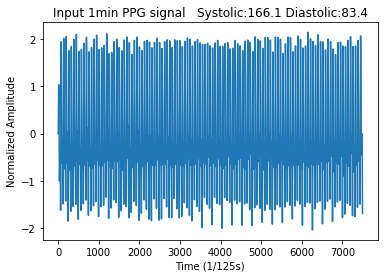

In [211]:
plt.plot(sig1)
plt.xlabel('Time (1/125s)')
plt.ylabel('Normalized Amplitude')
plt.title('Input 1min PPG signal' +'   Systolic:' + str(round(test_labels[0][0],1)) \
          + ' Diastolic:' + str(round(test_labels[0][1],1)))

###5.1.2 SmoothGrad

In [157]:
# Define loss function. 
def loss(output):
    return (output[0]) #score corresponding Systolic BP

In [158]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
saliency = Saliency(model, clone=False)

Wall time: 0 ns


In [275]:
X = [test_data[1],t_s0[1], t_c0[1]]
saliency_map = saliency(loss, X, smooth_samples=20)
sali_m= saliency_map[0].reshape([7500])

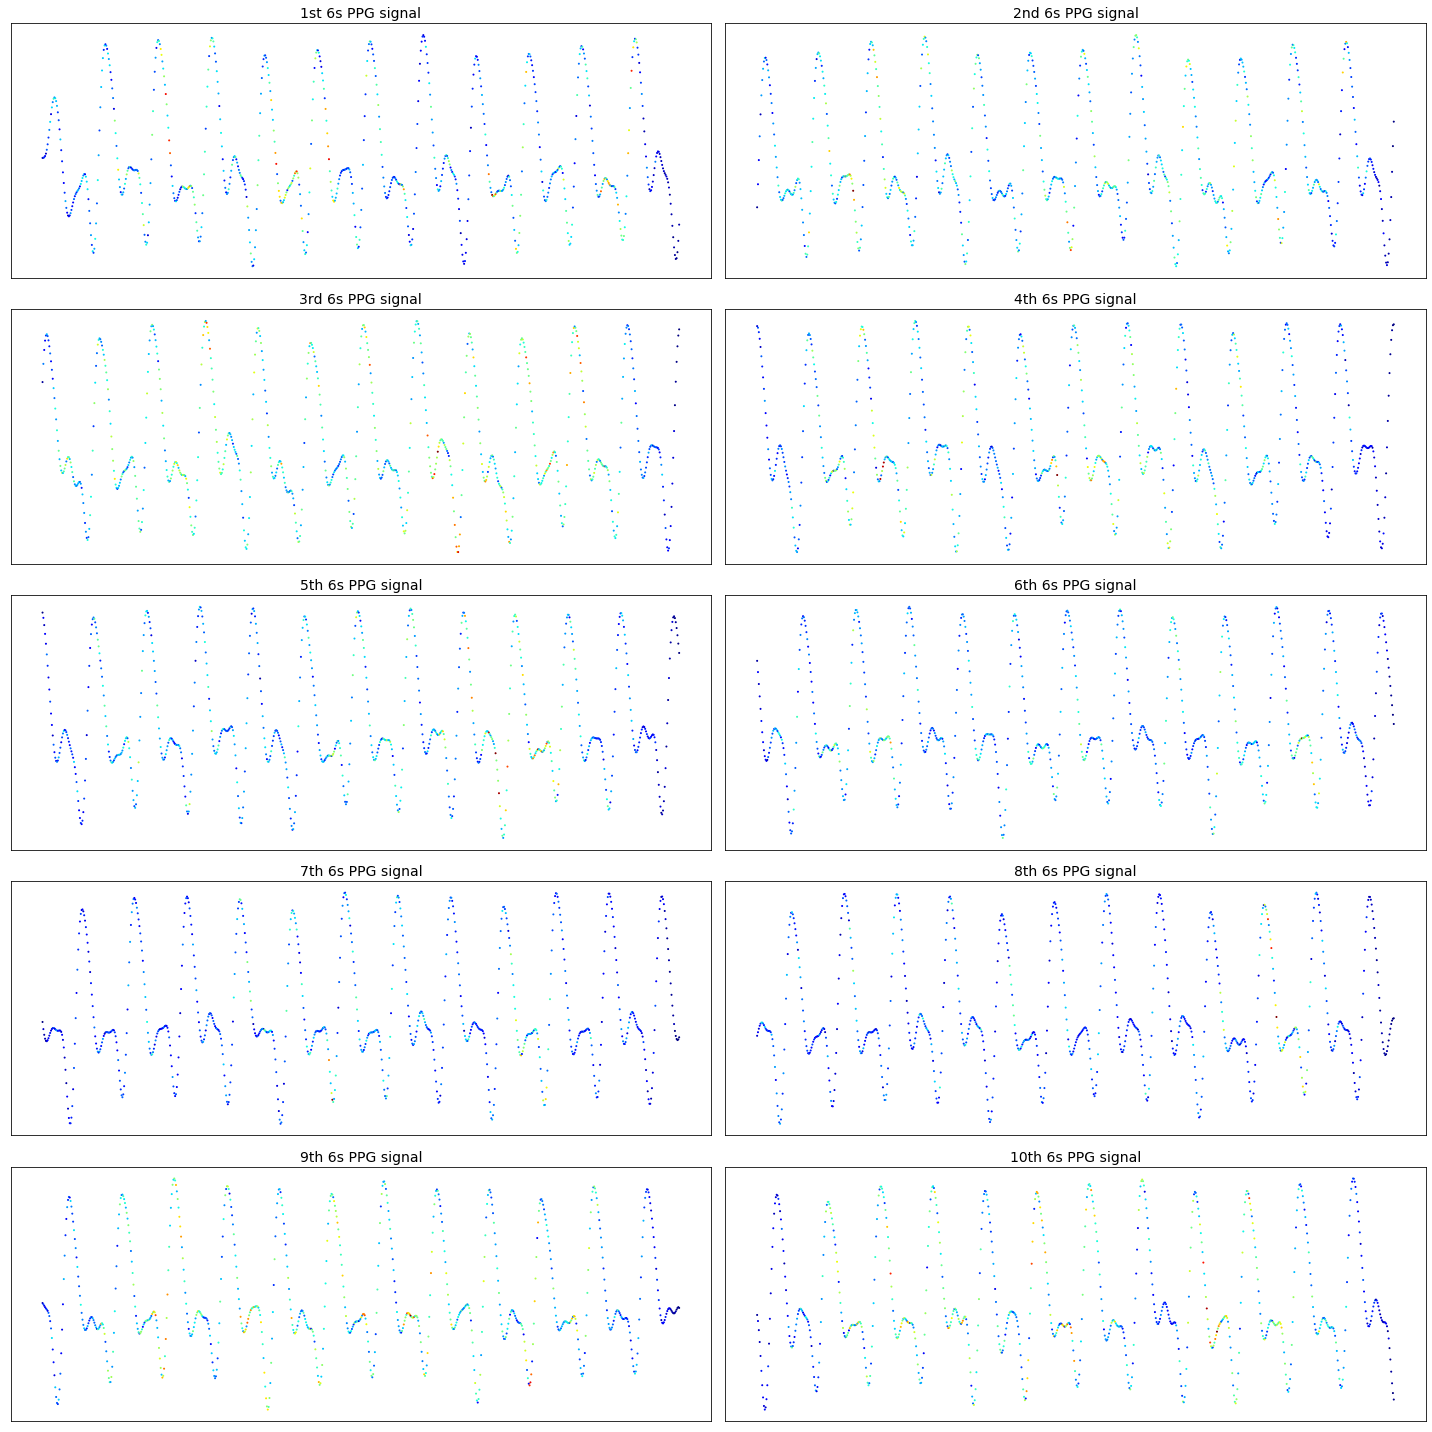

In [325]:
subprot_args = {
    'nrows': 5,
    'ncols': 2,
    'figsize': (20, 20),
    'subplot_kw': {'xticks': [], 'yticks': []}
}
image_titles = ['1st','2nd','3rd','4th','5th',
                '6th','7th','8th','9th','10th']
f, ax = plt.subplots(**subprot_args)
count = 0
for i in range(5):
  for j in range(2):
    ax[i,j].set_title(image_titles[count]+' 6s PPG signal',fontsize=14)
    ax[i,j].scatter(np.arange(len(sig1))[750*count:750*(count+1)],sig1[750*count:750*(count+1)],
                    c=sali_m[750*count:750*(count+1)],s=1,cmap="jet")
    count+=1
plt.tight_layout()
plt.show()

##5.2 Low-level feature maps

In [ ]:
#visualize early layers

In [ ]:
model.summary()

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

In [ ]:
model.layers[1]

In [ ]:
layer_name = 'time_distributed'
model = Model(inputs = model.inputs, outputs = layer_dict[layer_name].output)

In [ ]:
ppg_sample = np.asarray(test_data)[1]
ppg_sample = np.expand_dims(ppg_sample, axis=0)
ppg_sample.shape

(1, 10, 750, 1)

In [ ]:
n_a=32 #Number of pre-LSTM states
n_s=16 #Number of post-LSTM states
t_s0 = np.zeros((1, n_s))
t_c0 = np.zeros((1, n_s))

feature_maps = model.predict([ppg_sample,t_s0, t_c0])

In [ ]:
feature_maps.shape

(1, 10, 5632)

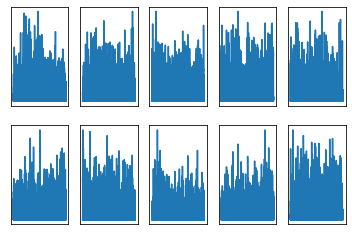

In [ ]:
row = 2
col = 5
index = 1
for _ in range(row):
  for _ in range(col):
    
    ax = plt.subplot(row, col, index)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.plot(feature_maps[0,index-1,:])
    index += 1

plt.show()

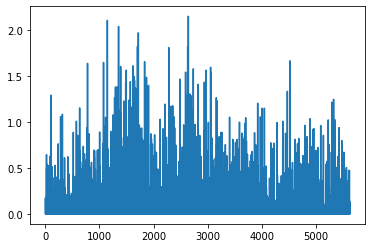

In [ ]:
plt.plot(feature_maps[0,0,:])

##5.3 High-level feature space (t-SNE)

https://www.tensorflow.org/tutorials/text/word_embeddings

Input: output of a layer \
Output: 2D embedding map

##5.4 Grad-CAM

https://arxiv.org/abs/1610.02391